# Use case description

The goal is to understand when a building construction is started using satellite images. 
- The approach should work also on very low quality satellite images
- Implementation would be a lot faster if the approach wouldn't need any model training.
- We can assume that areas where expected construction should happen can be pinpointed using GPS coordinates so we know where the construction should take place, but not when it starts.
- Below two images are displayed. The source image is the original satellite image and the modified image contains two additional grey areas that resemble a change that could relate to construction. 

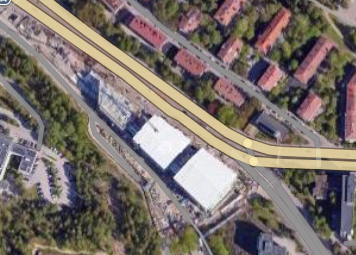

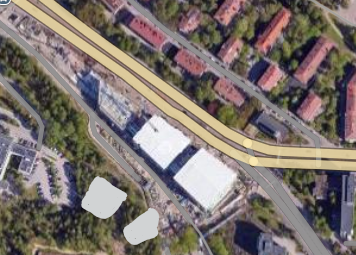

In [24]:
from IPython.display import Image
from IPython.display import display
x = Image(filename='Satellite_source.png') 
y = Image(filename='Satellite_modified.png') 
display(x, y)

# Import required packages & create Viya CAS connection

In [2]:
#Swat package required for SAS Viya connection
import swat

In [3]:
#Create connection, specify your own viyaurl etc.
conn= swat.CAS(viyaurl, port, username, password)
conn.serverstatus()

NOTE: Grid node action status report: 1 nodes, 8 total actions executed.


[About]

 {'CAS': 'Cloud Analytic Services',
  'Version': '4.00',
  'VersionLong': 'V.04.00M0P08122024',
  'Viya Release': '20240928.1727531156604',
  'Viya Version': 'Stable 2024.08',
  'Copyright': 'Copyright © 2014-2024 SAS Institute Inc. All Rights Reserved.',
  'ServerTime': '2024-10-15T09:43:14Z',
  'System': {'Hostname': 'controller.sas-cas-server-default.cauki.svc.cluster.local',
   'OS Name': 'Linux',
   'OS Family': 'LIN X64',
   'OS Release': '5.15.0-1056-azure',
   'OS Version': '#64-Ubuntu SMP Tue Feb 6 19:23:34 UTC 2024',
   'Model Number': 'x86_64',
   'Linux Distribution': 'Red Hat Enterprise Linux release 8.10 (Ootpa)'},
  'license': {'site': 'VIYADSDEXT',
   'siteNum': 70180938,
   'expires': '01Feb2025:00:00:00',
   'gracePeriod': 0,
   'warningPeriod': 15},
  'CASHostAccountRequired': 'OPTIONAL',
  'Transferred': 'NO',
  'CASCacheLocation': 'CAS Disk Cache'}

[server]

 Server Status
 
    nodes  actions
 0      1        8

[nodestatus]

 Node Status
 
                                                 name        role  uptime  running  stalled
 0  controller.sas-cas-server-default.cauki.svc.cl...  controller   0.829        0        0

+ Elapsed: 0.000594s, user: 0.000516s, sys: 3.8e-05s, mem: 0.309mb

In [6]:
#Load necessary actionsets: 'image'
conn.loadactionset('image')

NOTE: Added action set 'image'.


[actionset]

 'image'

+ Elapsed: 0.000799s, user: 0.000613s, sys: 0.000101s, mem: 0.217mb

# Create a caslib

In [7]:
#Caslib required in this environment as loading images based on absolute paths is not allowed
conn.table.addcaslib(lib='data',
  datasource={'srcType' : 'path'},
  path="/export/home/users/ssfahe/shared/images",
  subdirectories=True)

ERROR: The caslib data is a duplicate, parent or subpath of caslib data.
ERROR: Could not add caslib 'data'. Make sure that the caslib does not already exist and that you have permissions to add caslibs to Cloud Analytic Services.
ERROR: The action stopped due to errors.


+ Elapsed: 0.00221s, user: 0.000774s, sys: 0.000127s, mem: 0.328mb

# Load images

In [8]:
#In this environment imgsub is a subfolder of the caslib (/export/home/users/ssfahe/shared/images). The image(s) are located there.

#Load "new" images that will be compared to the original image
conn.image.loadImages(path='New_images/',
   caslib = 'data',
   casout=dict(name='New', blocksize='128',replace=True),
   recurse=True, 
   decode=True, labelLevels=-2)

NOTE: Loaded 2 images from /export/home/users/ssfahe/shared/images/New_images/ into table New.


,casLib,Name,Rows,Columns,casTable
0,data,New,2,9,"CASTable('New', caslib='data')"


In [9]:
#Load original / souce image
conn.image.loadImages(path='Source_images/',
   caslib = 'data',
   casout=dict(name='Source', blocksize='128',replace=True),
   recurse=True, 
   decode=True, labelLevels=-2)

NOTE: Loaded 1 image from /export/home/users/ssfahe/shared/images/Source_images/ into table Source.


,casLib,Name,Rows,Columns,casTable
0,data,Source,1,9,"CASTable('Source', caslib='data')"


In [10]:
#Check that image(s) have been loaded. See that width and height are correct.
conn.image.fetchImages(
    table = 'New'
)

NOTE: The table NEW contains decoded images.


,Image,Width,Height,Label
0,<PIL.JpegImagePlugin.JpegImageFile image mode=...,356.0,255.0,
1,<PIL.JpegImagePlugin.JpegImageFile image mode=...,356.0,255.0,


In [11]:
#Check that loaded images data table is in the correct caslib.
conn.tableinfo(caslib='data')

,Name,Rows,Columns,IndexedColumns,Encoding,CreateTimeFormatted,ModTimeFormatted,AccessTimeFormatted,JavaCharSet,CreateTime,View,MultiPart,SourceName,SourceCaslib,Compressed,Creator,Modifier,SourceModTimeFormatted,SourceModTime,TableRedistUpPolicy
0,NEW,2,9,0,utf-8,2024-10-15T10:07:15+00:00,2024-10-15T10:07:15+00:00,2024-10-15T10:07:25+00:00,UTF8,2.044606e+09,0,0,,,0,ssfahe,,,NaN,Not Specified
1,SOURCE,1,9,0,utf-8,2024-10-15T10:07:20+00:00,2024-10-15T10:07:20+00:00,2024-10-15T10:07:20+00:00,UTF8,2.044606e+09,0,0,,,0,ssfahe,,,NaN,Not Specified


In [12]:
#View contents of the loaded images table. It should show nonsensical binary content.
tbl = conn.CASTable('SOURCE', caslib='data')
tbl.head()

,_dimension_,_resolution_,_imageFormat_,_image_,_size_,_path_,_label_,_type_,_id_
0,2,b'd\x01\x00\x00\x00\x00\x00\x00\xff\x00\x00\x0...,16,b'\xca\xc2\xb9\xf5\xf3\xf2\xcb\xc4\xbb\xcb\xc4...,272340,/export/home/users/ssfahe/shared/images/Source...,,bmp,1


In [13]:
#Check summary of images
conn.image.summarizeImages(
    table='NEW'
)

NOTE: The table NEW contains decoded images.
NOTE: 2 out of 2 images were scanned and results were saved to the summary table.


,Column,bmp,minWidth,maxWidth,minHeight,maxHeight,meanWidth,meanHeight,mean1stChannel,min1stChannel,max1stChannel,mean2ndChannel,min2ndChannel,max2ndChannel,mean3rdChannel,min3rdChannel,max3rdChannel
0,_image_,2.0,356.0,356.0,255.0,255.0,356.0,255.0,107.947951,0.0,255.0,113.06741,0.0,255.0,122.915119,0.0,255.0


# Get RGB pixel values

In [17]:
#https://go.documentation.sas.com/doc/en/pgmcdc/8.11/casactml/casactml_image_examples138.htm
#Couple of options are available for flattening

#In this example images are resized to 2x2 to limit number of produced columns. It is recommended to resize to smaller dimensions if you images are large. E.g. 600x600 image will produce 600x600x3 = 1 080 000 columns
conn.image.flattenImages(
    casout=dict(name='FLATTENED', replace=True),
    table={'name':'NEW'},
    w = 2,
    h = 2
)

NOTE: 2 out of 2 images were processed successfully and saved to the table FLATTENED.


,casLib,Name,Rows,Columns,casTable
0,data,FLATTENED,2,14,"CASTable('FLATTENED', caslib='data')"


In [18]:
#Check that casout table has been created
conn.tableinfo(caslib='data')

,Name,Rows,Columns,IndexedColumns,Encoding,CreateTimeFormatted,ModTimeFormatted,AccessTimeFormatted,JavaCharSet,CreateTime,View,MultiPart,SourceName,SourceCaslib,Compressed,Creator,Modifier,SourceModTimeFormatted,SourceModTime,TableRedistUpPolicy
0,NEW,2,9,0,utf-8,2024-10-15T10:07:15+00:00,2024-10-15T10:07:15+00:00,2024-10-15T10:15:13+00:00,UTF8,2.044606e+09,0,0,,,0,ssfahe,,,NaN,Not Specified
1,SOURCE,1,9,0,utf-8,2024-10-15T10:07:20+00:00,2024-10-15T10:07:20+00:00,2024-10-15T10:10:22+00:00,UTF8,2.044606e+09,0,0,,,0,ssfahe,,,NaN,Not Specified
2,COMP_TBLOUT,2,6,0,utf-8,2024-10-15T10:10:22+00:00,2024-10-15T10:10:22+00:00,2024-10-15T10:10:35+00:00,UTF8,2.044606e+09,0,0,,,0,ssfahe,,,NaN,Not Specified
3,FLATTENED,2,14,0,utf-8,2024-10-15T10:15:13+00:00,2024-10-15T10:15:13+00:00,2024-10-15T10:15:13+00:00,UTF8,2.044607e+09,0,0,,,0,ssfahe,,,NaN,Not Specified


In [19]:
#Check the pixel values. With the demo images it should show that one pixel in the 2x2 grid is different between the images (columns c7-c9). 
tbl = conn.CASTable('FLATTENED', caslib='data')
tbl.head()

,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,c11,c12,_path_,_label_
0,92.0,84.0,105.0,62.0,29.0,37.0,37.0,60.0,67.0,145.0,145.0,147.0,/export/home/users/ssfahe/shared/images/New_im...,
1,92.0,84.0,105.0,62.0,29.0,37.0,203.0,204.0,202.0,145.0,145.0,147.0,/export/home/users/ssfahe/shared/images/New_im...,


# Compare Images

In [14]:
#https://go.documentation.sas.com/doc/en/pgmsascdc/v_055/casactcv/cas-image-compareimages.htm
conn.image.compareImages(                                                         
    sourceImages={"table":{"caslib":"data","name":"SOURCE"}},
    referenceImages={"table":{"caslib":"data","name":"NEW"}},
    casOut={"name":"comp_tblOut", "replace":True},
    pairAll=True
)

,casLib,Name,Rows,Columns,casTable
0,data,comp_tblOut,2,6,"CASTable('comp_tblOut', caslib='data')"


In [15]:
conn.tableinfo(caslib='data')

,Name,Rows,Columns,IndexedColumns,Encoding,CreateTimeFormatted,ModTimeFormatted,AccessTimeFormatted,JavaCharSet,CreateTime,View,MultiPart,SourceName,SourceCaslib,Compressed,Creator,Modifier,SourceModTimeFormatted,SourceModTime,TableRedistUpPolicy
0,NEW,2,9,0,utf-8,2024-10-15T10:07:15+00:00,2024-10-15T10:07:15+00:00,2024-10-15T10:10:22+00:00,UTF8,2.044606e+09,0,0,,,0,ssfahe,,,NaN,Not Specified
1,SOURCE,1,9,0,utf-8,2024-10-15T10:07:20+00:00,2024-10-15T10:07:20+00:00,2024-10-15T10:10:22+00:00,UTF8,2.044606e+09,0,0,,,0,ssfahe,,,NaN,Not Specified
2,COMP_TBLOUT,2,6,0,utf-8,2024-10-15T10:10:22+00:00,2024-10-15T10:10:22+00:00,2024-10-15T10:10:22+00:00,UTF8,2.044606e+09,0,0,,,0,ssfahe,,,NaN,Not Specified


In [16]:
#The source image should receive perfect 1.0 correlation with the source image copy
#The correlation between the modified image should be slightly less
tbl2 = conn.CASTable('COMP_TBLOUT', caslib='data')
tbl2.head()

,_channel1_,_channel2_,_channel3_,_channel4_,_source_id_,_reference_id_
0,1.000000,1.000000,1.00000,1.0,Satellite_source.bmp,Satellite_source_copy.bmp
1,0.971379,0.972151,0.97277,1.0,Satellite_source.bmp,Satellite_modified.bmp
